In [40]:
import numpy as np
#import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import pickle

from abc import ABC, abstractmethod

import os
from scipy.special import softmax

from skopt import gp_minimize, forest_minimize, Optimizer
from skopt.space import Real, Integer

from numpy import ndarray

from joblib import Parallel, delayed
# example objective taken from skopt
from skopt.benchmarks import branin


# Traccia A3
L’obiettivo del progetto è implementare e valutare una o più soluzioni basate su reinforcement learning per il problema Mountain Car della suite OpenAI Gymnasium: https://gymnasium.farama.org/environments/classic_control/mountain_car/

## Description
The Mountain Car MDP is a deterministic environment where a car must reach the top of a hill by overcoming gravity. The car is initially placed in a valley, and the agent needs to apply strategic accelerations to reach the goal.

## Observation Space
- **Shape:** `(2,)`
- **Elements:**
  - Position: `[-1.2, 0.6]` (meters)
  - Velocity: `[-0.07, 0.07]` (meters/second)

## Action Space
- **Discrete(3)**
  1. Accelerate left
  2. No acceleration
  3. Accelerate right

## Transition Dynamics
- Updates based on applied force, velocity, and gravity. Inelastic collisions occur at boundaries.

## Reward
- Constant reward of `-1` per timestep until the goal is reached.

## Starting State
- Position: Uniform random in `[-0.6, -0.4]`
- Velocity: `0`

## Episode End
1. **Termination:** Position ≥ 0.5 (goal reached)
2. **Truncation:** 200 timesteps


In [41]:
MAX_EPISODE_STEPS = 200
SPACE_RANGE = [-1.2, 0.6]
VEL_RANGE = [-0.07, 0.07]
ACTION_SPACE = 3

In [42]:
class Learner(ABC) :

    def __init__(self, alpha : float, gamma : float) :
        
        self.env : gym.Env = gym.make('MountainCar-v0')
        self.rng = None
        self.seed = None

        self.alpha = alpha
        self.gamma = gamma


    def oneEpisode(self, episodeIdx : int, training : bool) -> tuple[list, list, list]:
        currentState = self.env.reset()[0]
        terminated = False
        totalReward = 0
        spaceArray = []
        velArray = []
        for episodeStep in range(0, MAX_EPISODE_STEPS) :

            if (not training) :
                spaceArray.append(currentState[0])
                velArray.append(currentState[1])

            action = self.chooseNextAction(currentState, episodeIdx, episodeStep, training)
            nextState, reward, terminated, _, _ = self.env.step(action)
            if training :
                self.updateFunction(currentState, nextState, reward, action, episodeIdx, episodeStep)

            currentState = nextState
            totalReward += reward
            if (terminated) :
                break

        if (not training) :
            spaceArray.append(currentState[0])
            velArray.append(currentState[1])
        
        return totalReward, spaceArray, velArray


    def learn(self, episodeNum : int, seed : int) -> np.ndarray :
        self.env = gym.Env = gym.make('MountainCar-v0')
        self.env.reset(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray= np.zeros(episodeNum)
        for episodeIdx in range(0, episodeNum) :
            episodeReward, _, _  = self.oneEpisode(episodeIdx, True)
            rewardArray[episodeIdx] = episodeReward

            self.updateAfterEpisode(episodeNum, episodeIdx)
        
        self.env.close()

        return rewardArray
    

    def test(self, episodeNum : int, seed : int, display : bool) -> tuple[np.ndarray, list, list]:
        self.env = gym.Env = gym.make('MountainCar-v0', render_mode = "human" if display else None)
        self.env.reset(seed = seed)
        self.env.action_space.seed(seed = seed + 10)
        self.rng = np.random.default_rng(seed = seed + 20)

        rewardArray = np.zeros(episodeNum)
        spaceMatrix = []
        velMatrix = []
        for episodeIdx in range(0, episodeNum) :
            episodeReward, spaceArray, velArray  = self.oneEpisode(episodeIdx, False)
            rewardArray[episodeIdx] = episodeReward
            spaceMatrix.append(spaceArray)
            velMatrix.append(velArray)

        self.env.close()
        return rewardArray, spaceMatrix, velMatrix
 
    def computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return (spaceSlot, velocitySlot)

    @abstractmethod
    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx) :
        pass

    @abstractmethod
    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int : 
        pass

    @abstractmethod
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None:
        pass


In [43]:
class QFunction(ABC) :

    @abstractmethod
    def updateFunction(self, currentState, action, nextState, alpha, target, *args) :
        pass

    @abstractmethod
    def getValue(self, state, action) -> float :
        pass

    @abstractmethod
    def getValues(self, state) -> np.ndarray :
        pass

In [44]:
TRAIN_SEED = 0
TUNE_SEED = 1
TEST_SEED = 2

TUNER_RANDOM_STATE = 3

# Soluzione con ricerca tabulare
Per definire delle soluzioni basate su ricerca tabulare, abbiamo bisogno prima di tutto di una matrice che ci tenga traccia dei valori della funzione $Q(s,a)$. In questo caso specifico lo stato del problema non è discreto, bensì continuo, in quanto formato da i valori della posizione e della velocità i quali a loro volta variano in un insieme continuo.

Al fine di definire delle soluzioni basate su ricerca tabulare quindi definiamo una discretizzazione dello stato che ci permetta di definire la funzione $Q(s,a)$; notiamo invece che per quanto riguarda l'insieme $A$ delle azioni esso è già discreto e non ci dà problemi in termini di definizione della funzione.

Una soluzione basata su questo tipo di soluzioni comporta un consumo di memoria dato da $|S| \cdot |A|$, dove $|A|$ nel nosto caso è pari a $3$, mentre $|S|$ dipende dalla discretizzazione che facciamo dello stato: supposto di dividere l'inervallo della posizione in $5$ slot e quello delle velocità in altrettanti, avremo un numero totale di stati pari a $25$.

In [45]:
class BucketQFunction(QFunction) :

    def __init__(self, spaceRange : list, spaceBins : int, velRange : list, velBins : int, actionSpace : int) :
        self.q : np.ndarray = np.zeros([spaceBins, velBins, actionSpace])

        self.spaceLinSpace = np.linspace(
            spaceRange[0], 
            spaceRange[1], 
            spaceBins + 1
        )

        self.velLinSpace = np.linspace(
            velRange[0], 
            velRange[1], 
            velBins + 1
        )

    def updateFunction(self, currentState, action, nextState, alpha, target, *args):
        spaceSlot, velSlot = self._computeSlots(currentState)
        increment = alpha * (target - self.getValue(currentState, action))

        self.q[spaceSlot, velSlot, action] += increment
    
    def getValue(self, state, action):
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, action]
    
    def getValues(self, state) :
        spaceSlot, velSlot = self._computeSlots(state)
        return self.q[spaceSlot, velSlot, :]
    
    def _computeSlots(self, state) -> tuple[int, int] :
        spaceSlot = np.digitize(state[0], self.spaceLinSpace) - 1
        velocitySlot = np.digitize(state[1], self.velLinSpace) - 1
        return spaceSlot, velocitySlot

## Algoritmi

### Q-Learning
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma \cdot max_{a} Q(S',a) - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [46]:
class QLearner(Learner) :

    def __init__(self, alpha : float, gamma : float, epsilon : float, qFunction : QFunction) :
        super().__init__(alpha, gamma)
        self.q : QFunction = qFunction
        self.epsilon = epsilon

    def chooseNextAction(self, state, episodeIdx, episodeStep, training: bool) -> int:
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.q.getValues(state))
        else :
            action = np.argmax(self.q.getValues(state))
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        target = reward + self.gamma * np.max(self.q.getValues(nextState))
        self.q.updateFunction(currentState, action, nextState, self.alpha, target)

    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx):
        self.epsilon = max(self.epsilon - 2 / totalEpisodeNum, 0.0)
        #self.alpha = max(self.epsilon - self.decay, 0.01)

### SARSA
Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata

In [47]:
class SarsaLearner(Learner) :

    def __init__(self, alpha : float, gamma : float, epsilon : float, qFunction : QFunction) :
        super().__init__(alpha, gamma)
        self.q : QFunction = qFunction
        self.epsilon = epsilon

    def chooseNextAction(self, state, episodeIdx, episodeStep, training: bool) -> int:
        if training :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.q.getValues(state))
        else :
            action = np.argmax(self.q.getValues(state))
        return action
        
    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        nextAction = self.chooseNextAction(nextState, episodeIdx, episodeStep, True)
        target = reward + self.gamma * self.q.getValue(nextState, nextAction)
        self.q.updateFunction(currentState, action, nextState, self.alpha, target)

    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx):
        self.epsilon = max(self.epsilon - 2 / (totalEpisodeNum), 0.0)

### Expected-SARSA

Analizziamo prima di tutto una soluzione basata sul Q-Learning. In questo tipo di algoritmo l'aggiornamento della Q-Function è defintio come

$Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma E_{\pi}[Q(S',A') | S'] - Q(S,A)]$

e

$E_{\pi}[Q(S',A') | S'] = \sum_{a} \pi(a | S')Q(S',a)$

Dove:
* $S'$ è lo stato a cui si passa partendo da S ed eseguendo l'azione A
* $A'$ è l'azione successiva scelta nello stato $S'$ con la stessa regola usata
* $R$ è il guadagno ottenuto dall'azione A nello stato S

In [48]:
class ExpectedSarsaLearner(Learner) :

    def __init__(self, alpha : float, gamma : float, epsilon : float, qFunction : QFunction) :
        super().__init__(alpha, gamma)
        self.q : QFunction = qFunction
        self.epsilon = epsilon

    def chooseNextAction(self, state, episodeIdx, episodeStep, training : bool) -> int:
        if (training) :
            if (self.rng.random() < self.epsilon) :
                action = self.env.action_space.sample()
            else :
                action = np.argmax(self.q.getValues(state))
        else :
            action = np.argmax(self.q.getValues(state))
        
        return action

    def updateFunction(self, currentState, nextState, reward, action, episodeIdx, episodeStep) -> None :
        expectedNextQValue = self.computeExpectedQValue(nextState, episodeIdx, episodeStep)
        target = reward + self.gamma * expectedNextQValue
        self.q.updateFunction(currentState, action, nextState, self.alpha, target)

    def updateAfterEpisode(self, totalEpisodeNum, episodeIdx):
        self.epsilon = max(self.epsilon - 2 / (totalEpisodeNum), 0.0)


    def computeExpectedQValue(self, nextState, episodeIdx, episodeStep) :
        expectedQ = 0
        qMax = np.max(self.q.getValues(nextState))
        greedyActions = 0
        for action in range(self.env.action_space.n) :
            if (self.q.getValue(nextState, action) == qMax) :
                greedyActions += 1

        nonGreedyProb = self.epsilon / self.env.action_space.n
        greedyProb = (1 - self.epsilon) / greedyActions + nonGreedyProb
        for action in range(self.env.action_space.n) :
            if (self.q.getValue(nextState, action) == qMax) :
                expectedQ += self.q.getValue(nextState, action) * greedyProb
            else :
                expectedQ += self.q.getValue(nextState, action) * nonGreedyProb
        
        return expectedQ

## Tuning

Di seguito si procede alla sintonizzazione degli iperparametri; come iperparametri da sintonizzare sono stati considerati solamente due dei possibili, ovvero:
* $\alpha$, cioè il learning rate
* $\gamma$, cioè il fattore di sconto

Per quanto riguarda gli altri valori sono stati scelti empiricamente facendo qualche prova manuale:
* Per il parametro di esplorazione $\epsilon$ si è scelta un'inizializzazione ad $1$ con decremento lineare
* Numero di beans: Il numero di intervalli in cui suddividere lo stato dello spazio e della velocità sono stati supposti uguali e posti al valore $20$. La scelta è stata dettata dal fatto che si tratta di un valore che permette una suddivisione non eccessivamente fitta dei due stati pur mantenendo una grana abbastanza fine; lo spazio infatti è suddiviso in intervalli di dimensione $0.09$, mentre la velocità in intervalli di dimensione $0.007$

Essendo le singole Run di sintonizzazione piuttosto lunghe, i valori una volta calcolati vengono salvati su un file in modo tale da non doverli calcolare una seconda

In [49]:
TRAIN_EPISODES = 15_000

In [50]:
class Tuner() :

    def __init__(self, LearnerClass : Learner, trainEpisodes : int, tuneEpisodes : int, trainSeed : int, tuneSeed : int) :
        self.LearnerClass = LearnerClass
        self.trainEpisodes = trainEpisodes
        self.tuneEpisodes = tuneEpisodes
        self.trainSeed = trainSeed
        self.tuneSeed = tuneSeed

    def objective(self, params):
        alpha, gamma, epsilon, bins = params
        learner : Learner = self.LearnerClass(
            alpha, gamma, epsilon,
            BucketQFunction(SPACE_RANGE, bins, VEL_RANGE, bins, ACTION_SPACE)
        )
        trainRewardArray = learner.learn(self.trainEpisodes, self.trainSeed)
        tuneRewardArray, _, _ = learner.test(self.tuneEpisodes, self.tuneSeed, False)
        
        meanTune = -tuneRewardArray.mean()
        stdDev = np.sqrt(tuneRewardArray.var())
        objValue = meanTune + stdDev
        return objValue
    
    def tune(self, calls, randomState, space, jobsNum) :

        optimizer = Optimizer(
            dimensions = space, 
            random_state = randomState,
        )

        for i in range(calls // jobsNum):
            print(f"Step >>> {i}")
            x = optimizer.ask(n_points=jobsNum)  # x is a list of n_points points
            # for params in x :
            #     print(f"Attempt >>> {params}")
                
            y = Parallel(
                n_jobs = jobsNum
            )(delayed(self.objective)(params) for params in x)  # evaluate points in parallel
            optimizer.tell(x, y)

            bestIdx = np.argmin(optimizer.yi)
            print(f"Best Value So Far >>> {optimizer.yi[bestIdx]}")
            print(f"Best Params So Far >>> {optimizer.Xi[bestIdx]}")
            print()
        
        bestIdx = np.argmin(optimizer.yi)
        print(f"Best Value >>> {optimizer.yi[bestIdx]}")
        print(f"Best Params >>> {optimizer.Xi[bestIdx]}")
        print()
        print()

        return optimizer.Xi[bestIdx]

In [51]:
def tuneLearner(LearnerClass, trainEpisodes, bestDict, fileName : str) -> list :
    key = LearnerClass.__name__
    if (not key in bestDict) :
        space = [
            Real(0.01, 0.9, name = 'alpha'),
            Real(0.8, 0.99, name = 'gamma'),
            Real(0.5, 1.0, name = "epsilon"),
            Integer(10, 25, prior = "uniform", name = "bins"),
        ]
        bestParams = Tuner(LearnerClass, trainEpisodes, 100, TRAIN_SEED, TUNE_SEED).tune(75, TUNER_RANDOM_STATE, space, 5)
        bestDict[key] = bestParams
        with open(fileName, 'wb') as f:
            pickle.dump(bestDict, f)
    else :
        bestParams = bestDict[key]

    return bestParams

In [64]:
BEST_PARAMS_FILE_NAME = './BestParamsDict.pkl'

if (os.path.exists(BEST_PARAMS_FILE_NAME)) :
    with open(BEST_PARAMS_FILE_NAME, 'rb') as f:
        bestDict = pickle.load(f)
else :
    bestDict = {}

tuneLearner(QLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME)
tuneLearner(SarsaLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME)
tuneLearner(ExpectedSarsaLearner, TRAIN_EPISODES, bestDict, BEST_PARAMS_FILE_NAME)

Step >>> 0


Best Value So Far >>> 165.65140558719435
Best Params So Far >>> [0.13673613712078278, 0.8867904769304996, 0.9368995907653075, 16]

Step >>> 1
Best Value So Far >>> 145.2663431290166
Best Params So Far >>> [0.16108776576976158, 0.9700054654065879, 0.5993253863658936, 22]

Step >>> 2


KeyboardInterrupt: 

In [ ]:
for key in bestDict :
    print(f"Best Params For {key} >>> {bestDict[key]}")

Best Params For QLearner >>> [0.20967158955539328, 0.99, 1.0, 19]
Best Params For SarsaLearner >>> [0.1059573383767945, 0.983108744214725, 1.0, 20]


## Addestramento

In [ ]:
def plotTrainTrend(rewardArray : np.ndarray, episodeNum : int, learnerName : str) :
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

    axes[0].plot(np.array(rewardArray))
    axes[0].set_xlabel("Episode Idx")
    axes[0].set_ylabel("Reward")
    axes[0].set_title("Reward During Training")
    axes[0].grid(True)
    
    mean_rewards = np.zeros(episodeNum)
    for t in range(episodeNum):
            mean_rewards[t] = np.mean(rewardArray[max(0, t-100):(t+1)])
    axes[1].plot(mean_rewards)
    axes[1].set_xlabel("Episode Idx")
    axes[1].set_ylabel("Avg Reward - 100 Episodes")
    axes[1].set_title("Avg Reward Trend")
    axes[1].grid(True)

    fig.suptitle(f"{learnerName} - Training")
    plt.tight_layout()
    plt.show()
    plt.clf()

In [ ]:
TRAINED_TABULAR_FILE = "./TabularTrained.pkl"
def trainLearner(LearnerClass, trainDict, bestParamsDict, episodeNum) -> Learner :
    key = (LearnerClass.__name__)
    if (not key in trainDict) :
        alpha, gamma, epsilon, bins = bestParamsDict[key]
        learner = LearnerClass(
            alpha, 
            gamma, 
            epsilon, 
            BucketQFunction(SPACE_RANGE, bins, VEL_RANGE, bins, ACTION_SPACE)
        )

        rewardArray = learner.learn(episodeNum, TRAIN_SEED)
        
        trainDict[key] = [learner, rewardArray]
        with open(TRAINED_TABULAR_FILE, 'wb') as f:
            pickle.dump(trainDict, f)
    else :
        learner : Learner = trainDict[key][0]
        rewardArray = trainDict[key][1]
    
    plotTrainTrend(rewardArray, episodeNum, key)

    return learner, rewardArray

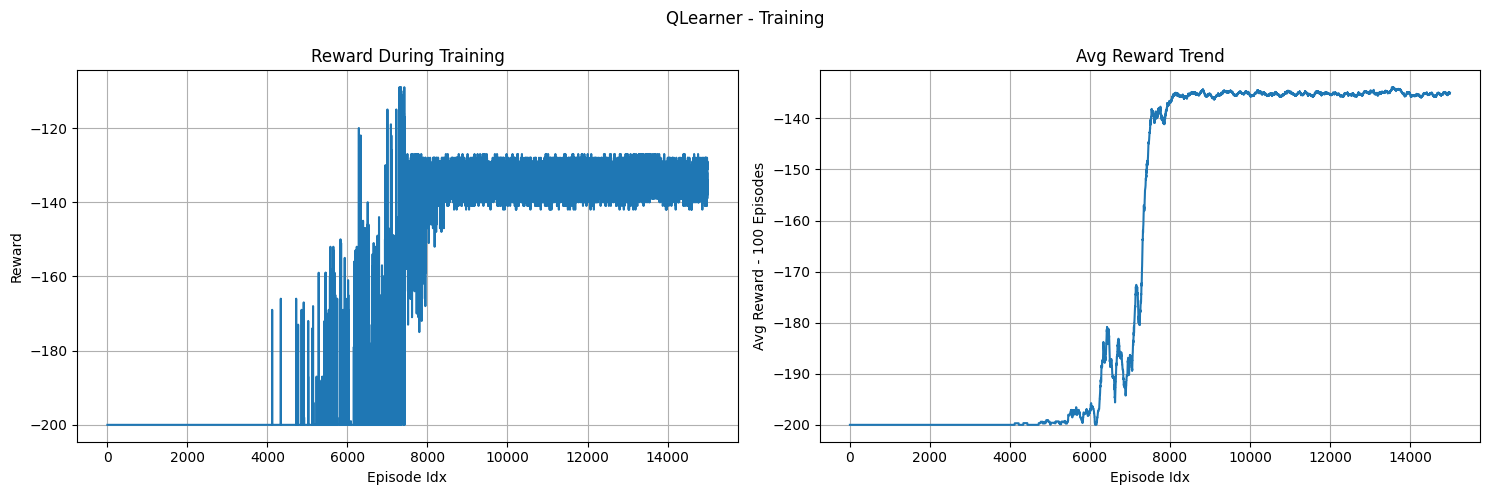

<Figure size 640x480 with 0 Axes>

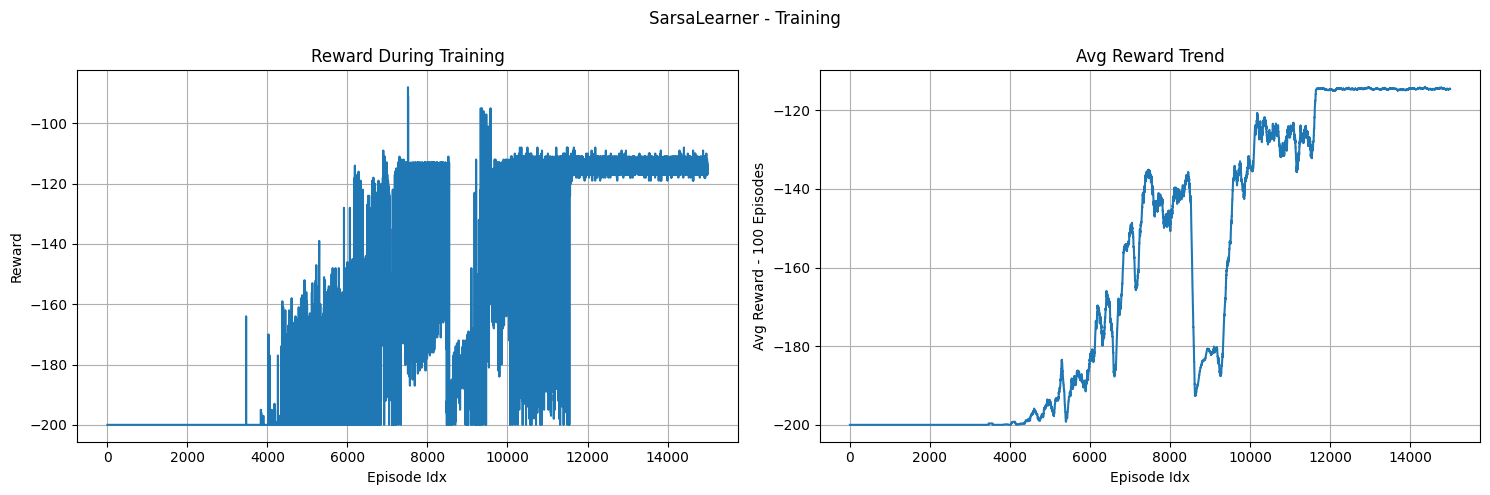

<Figure size 640x480 with 0 Axes>

In [ ]:
if (os.path.exists(TRAINED_TABULAR_FILE)) :
    with open(TRAINED_TABULAR_FILE, 'rb') as f:
        trainDict = pickle.load(f)
else :
    trainDict = {}
    
qLearner, _ = trainLearner(QLearner, trainDict, bestDict, TRAIN_EPISODES)
sarsaLearner, _ = trainLearner(SarsaLearner, trainDict, bestDict, TRAIN_EPISODES)
# expectedSarsaLearner, _ = trainLearner(ExpectedSarsaLearner, trainDict, bestDict, TRAIN_EPISODES)

## Testing

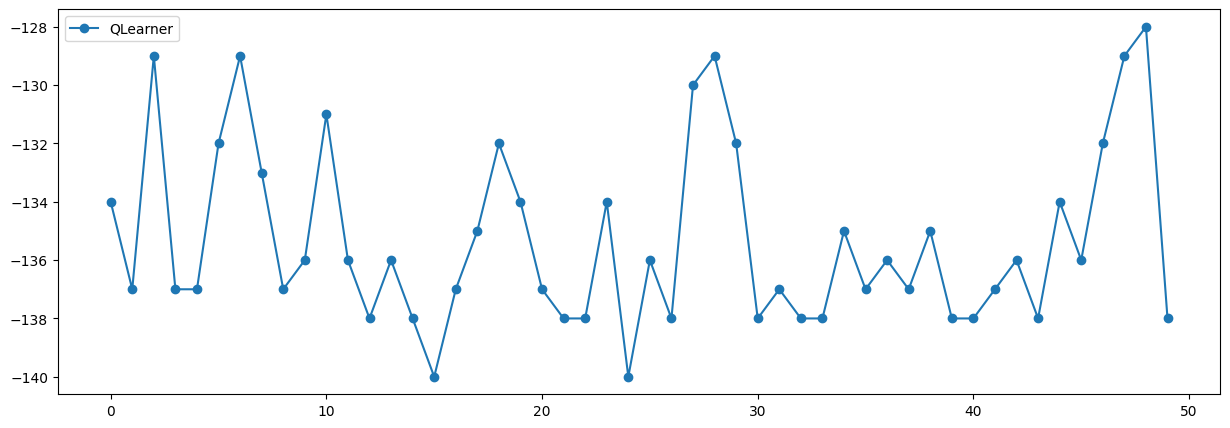

<Figure size 640x480 with 0 Axes>

In [ ]:
learners = [qLearner]
plt.figure(figsize = (15, 5))
for learner in learners :
    rewardArray, _, _ = learner.test(50, TEST_SEED, False)
    plt.plot(rewardArray, label = learner.__class__.__name__, marker = "o")
plt.legend()
plt.show()
plt.clf()

## Confronto

# Soluzione con approssimazione

In [ ]:
class Approximator(ABC) :

    @abstractmethod
    def getCombination(self, state) -> np.ndarray :
        pass

    @abstractmethod
    def getDimension(self) -> int :
        pass

## Approssimazione Lineare

In [ ]:
from numpy import ndarray


class LinearQFunction(QFunction) :

    def __init__(self, approx : Approximator, actionSpace : int) :
        self.approx = approx
        self.actionSpace = actionSpace
        self.weights = np.random.random([self.actionSpace, approx.getDimension()])


    def getValue(self, state, action) -> float:
        return np.dot(self.weights[action], self.approx.getCombination(state))

    def getValues(self, state) -> ndarray:
        values = []
        for a in range(self.actionSpace) :
            values.append(self.getValue(state, a))
        return np.array(values)
    
    def updateFunction(self, currentState, action, nextState, alpha, target, *args):
        increment = alpha * (target - self.getValue(currentState, action)) * self.approx.getCombination(currentState)
        self.weights[action] += increment


class LinearApproximator(Approximator) :
    def getCombination(self, state) -> ndarray:
        combination = [state[0], state[1], state[0] * state[1], (state[0] ** 2) * state[1], state[0] * (state[1] ** 2)]
        return np.array(combination)
    
    def getDimension(self) -> int:
        return 5

## Approssimazione con DQN